# ウイルス感染症の数理シミュレーション（応用）: 補足資料
Julia言語で書いている

In [1]:
using DifferentialEquations
using ModelingToolkit
using Plots

# B型感染ウイルスの数理モデリング

## 解離・接着までのモデル

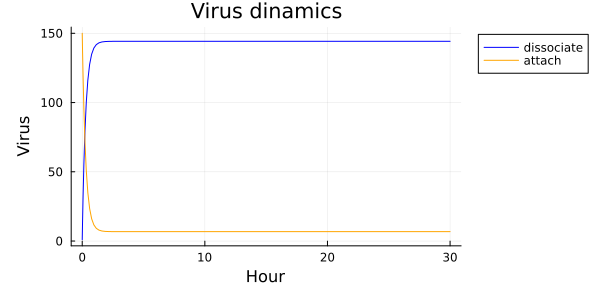

In [2]:
#| label: fig-HBV-middle
#| fig-cap: "解離・接着についての数理モデリング"
let
    @independent_variables t                     # <1>
    @variables V_dis(t)=1.0 V_att(t)=150.0       # <1>
    @parameters k_dis=3.4 k_att=0.16             # <2>
    
    D = Differential(t)                          # <3>
    eqs = [                                      # <3>
        D(V_dis) ~ k_dis * V_att - k_att * V_dis # <3>
        D(V_att) ~ k_att * V_dis - k_dis * V_att # <3>
    ]                                            # <3>
    @mtkbuild sys = ODESystem(eqs, t)            # <3>
    
    tspan = (0.0, 30.0)                          # <4>
    prob = ODEProblem(sys, [], tspan)            # <5>
    sol = solve(prob)                            # <5>
    
    dinamics_plot = plot(
        sol[t],
        [sol[V_dis], sol[V_att]],
        title="Virus dinamics",
        xlabel="Hour",
        ylabel="Virus",
        label=["dissociate" "attach"],
        color=[:blue :orange],
    )
        
    plot(
        dinamics_plot,
        size=(600, 300),
        left_margin = 20Plots.px,
        bottom_margin = 20Plots.px,
        legend=:outertopright,
    )
end

## 全状態を考慮したモデル

In [ ]:
function virus_dinamics(
    v::Dict{String, Float64},
    p::Dict{String, Float64},
    t_end::Float64=70.0 / 24.0,
)
    @independent_variables t                                                        # <1>
    @variables V_dis(t)=v["V_dis"]                                                  # <1>
    @variables V_att(t)=v["V_att"]                                                  # <1>
    @variables V_int(t)=v["V_int"]                                                  # <1>
    @variables V_ccc(t)=v["V_ccc"]                                                  # <1>
    @parameters k_dis=p["k_dis"]                                                    # <2>
    @parameters k_att=p["k_att"]                                                    # <2>
    @parameters k_int=p["k_int"]                                                    # <2>
    @parameters k_ccc=p["k_ccc"]                                                    # <2>
    @parameters k_di=p["k_di"]                                                      # <2>
    @parameters k_dc=p["k_dc"]                                                      # <2>
    @parameters K=p["K"]                                                            # <2>
    
    D = Differential(t)                                                             # <3>
    eqs = [                                                                         # <3>
        D(V_dis) ~ k_dis * V_att - k_att * V_dis                                    # <3>
        D(V_att) ~ k_att * V_dis - k_dis * V_att - k_int * V_att                    # <3>
        D(V_int) ~ k_int * V_att - k_ccc * (1 - V_ccc / K) * V_int - k_di * V_int   # <3>
        D(V_ccc) ~ k_ccc * (1 - V_ccc / K) * V_int - k_dc * V_ccc                   # <3>
    ]                                                                               # <3>
    @mtkbuild sys = ODESystem(eqs, t)                                               # <3>
    
    tspan = (0.0, t_end)                                                            # <4>
    prob = ODEProblem(sys, [], tspan)                                               # <5>
    return solve(prob)                                                              # <5>
end

virus_dinamics (generic function with 2 methods)

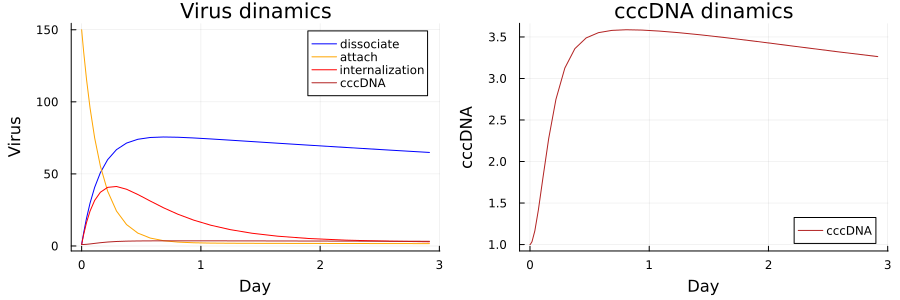

In [4]:
#| label: fig-HBV-all
#| fig-cap: "解離・接着についての数理モデリング"
let
    v::Dict{String, Float64} = Dict(
        "V_dis" => 1.0,
        "V_att" => 150.0,
        "V_int" => 1.0,
        "V_ccc" => 1.0,
    )
    p::Dict{String, Float64} = Dict(
        "k_dis" => 3.4,
        "k_att" => 0.16,
        "k_int" => 3.0,
        "k_ccc" => 0.65,
        "k_di" => 1.9,
        "k_dc" => 0.12,
        "K" => 3.7,
    )
    sol = virus_dinamics(v, p)
    u = reduce(hcat, sol.u)
    
    dinamics_plot = plot(
        sol.t,
        [u[1, :] u[2, :] u[3, :] u[4, :]],
        title="Virus dinamics",
        xlabel="Day",
        ylabel="Virus",
        label=["dissociate" "attach" "internalization" "cccDNA"],
        color=[:blue :orange :red :firebrick],
    )
    cccDNA_plot = plot(
        sol.t,
        u[4, :],
        title="cccDNA dinamics",
        xlabel="Day",
        ylabel="cccDNA",
        label="cccDNA",
        color=:firebrick,
    )
        
    plot(
        dinamics_plot,
        cccDNA_plot,
        size=(900, 300),
        left_margin = 20Plots.px,
        bottom_margin = 20Plots.px,
    )
end

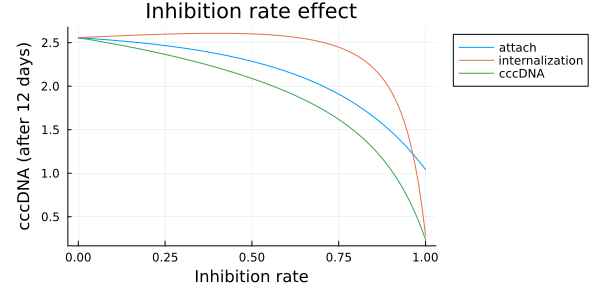

In [5]:
#| label: fig-HBV-inhibition
#| fig-cap: "活性阻害の効果"
let
    v::Dict{String, Float64} = Dict(
        "V_dis" => 1.0,
        "V_att" => 150.0,
        "V_int" => 1.0,
        "V_ccc" => 1.0,
    )
    p::Dict{String, Float64} = Dict(
        "k_dis" => 3.4,
        "k_att" => 0.16,
        "k_int" => 3.0,
        "k_ccc" => 0.65,
        "k_di" => 1.9,
        "k_dc" => 0.12,
        "K" => 3.7,
    )
    
    inhibition_rate = Vector(0:0.01:1)
    
    u_att::Vector{Float64} = Vector()
    u_int::Vector{Float64} = Vector()
    u_ccc::Vector{Float64} = Vector()
    
    for alpha = inhibition_rate
        p["k_att"] = (1 - alpha) * 0.16
        sol = virus_dinamics(v, p, 12.0)
        u = reduce(hcat, sol.u)
        push!(u_att, u[4, end])
    end
    p["k_att"] = 0.16
    
    for alpha = inhibition_rate
        p["k_int"] = (1 - alpha) * 3.0
        sol = virus_dinamics(v, p, 12.0)
        u = reduce(hcat, sol.u)
        push!(u_int, u[4, end])
    end
    p["k_int"] = 3.0
    
    for alpha = inhibition_rate
        p["k_ccc"] = (1 - alpha) * 0.65
        sol = virus_dinamics(v, p, 12.0)
        u = reduce(hcat, sol.u)
        push!(u_ccc, u[4, end])
    end
    p["k_ccc"] = 0.65
    
    cccDNA_plot = plot(
        inhibition_rate,
        [u_att u_int u_ccc],
        title="Inhibition rate effect",
        xlabel="Inhibition rate",
        ylabel="cccDNA (after 12 days)",
        label=["attach" "internalization" "cccDNA"],
    )
        
    plot(
        cccDNA_plot,
        size=(600, 300),
        left_margin = 20Plots.px,
        bottom_margin = 20Plots.px,
        legend=:outertopright,
    )
end

# エンテロウイルスの数理モデリング

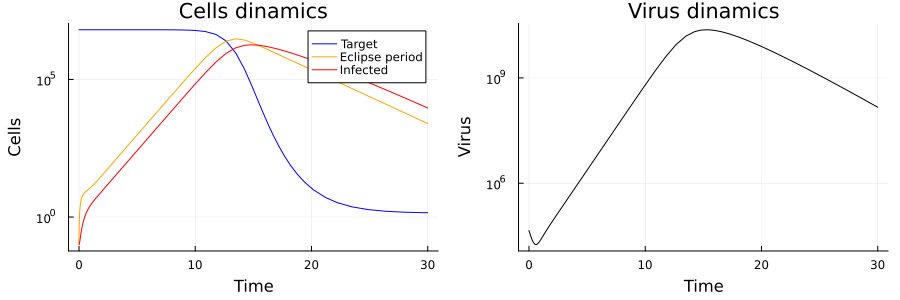

In [6]:
#| label: fig-EV71
#| fig-cap: "暗黒期を考慮した数理モデリング"
let
    @independent_variables t                                              # <1>
    @variables T(t)=6.4*10^6 E(t)=1.0*10^-1 I(t)=1.0*10^-1 V(t)=4.5*10^4  # <1>
    @parameters beta=1.0*10^-10 k=0.45 delta=0.55 p=3.3*10^4 c=2.5        # <2>
    
    D = Differential(t)                                                   # <3>
    eqs = [                                                               # <3>
        D(T) ~ - beta * T * V                                             # <3>
        D(E) ~ beta * T * V - k * E                                       # <3>
        D(I) ~ k * E - delta * I                                          # <3>
        D(V) ~ p * I - c * V                                              # <3>
    ]                                                                     # <3>
    @mtkbuild sys = ODESystem(eqs, t)                                     # <3>
    
    tspan = (0.0, 30.0)                                                   # <4>
    prob = ODEProblem(sys, [], tspan)                                     # <5>
    sol = solve(prob)                                                     # <5>
    
    cell_plot = plot(
        sol[t],
        [sol[T], sol[E], sol[I]],
        title="Cells dinamics",
        xlabel="Time",
        ylabel="Cells",
        label=["Target" "Eclipse period" "Infected"],
        color=[:blue :orange :red],
        yscale=:log10,
    )
        
    virus_plot = plot(
        sol[t],
        sol[V],
        title="Virus dinamics",
        xlabel="Time",
        ylabel="Virus",
        yscale=:log10,
        color=:black,
        legend=nothing,
    )
        
    plot(
        cell_plot,
        virus_plot,
        size=(900, 300),
        left_margin = 20Plots.px,
        bottom_margin = 20Plots.px,
    )
end

# ヒト免疫不全ウイルスの数理モデリング

観戦年齢分布はデルタ関数を仮定した。

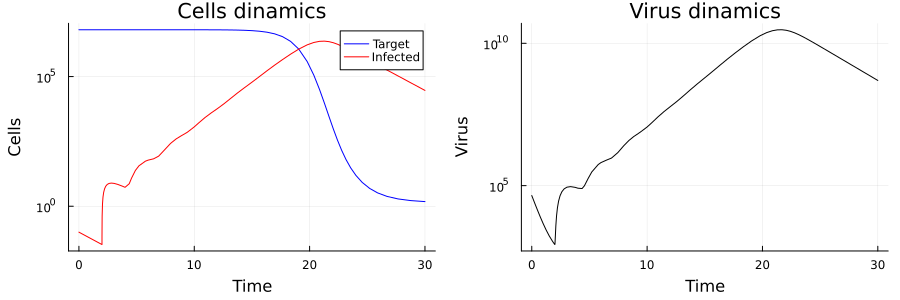

In [7]:
#| label: fig-HIV-delta
#| fig-cap: "暗黒期分布をデルタ関数と仮定した数理モデリング"
let
    function HIV_delta_model(du, u, h, params, t)                   # <1>
        beta, delta, p, c, tau = params                             # <1>
        t_tau = h(p, t - tau)[1]                                    # <1>
        v_tau = h(p, t - tau)[3]                                    # <1>
        du[1] = - beta * u[1] * u[3]                                # <1>
        du[2] = beta * t_tau * v_tau - delta * u[2]                 # <1>
        du[3] = p * u[2] - c * u[3]                                 # <1>
    end                                                             # <1>
    
    h(p, t) = ones(3)                                               # <2>
    beta = 1.0*10^-10;                                              # <2>
    delta = 0.55;                                                   # <2>
    p = 3.3*10^4;                                                   # <2>
    c = 2.5;                                                        # <2>
    tau = 2.0                                                       # <2>
    lags = [tau]                                                    # <2>
    params = (beta, delta, p, c, tau)                               # <2>

    tspan = (0.0, 30.0)                                             # <3>
    u0 = [6.4*10^6, 1.0*10^-1, 4.5*10^4]                            # <4>
    
    prob = DDEProblem(                                              # <5>
        HIV_delta_model, u0, h, tspan, params; constant_lags = lags # <5>
    )                                                               # <5>
    alg = MethodOfSteps(Tsit5())                                    # <5>
    sol = solve(prob, alg)                                          # <5>
    u = reduce(hcat, sol.u)
    
    cell_plot = plot(
        sol.t,
        [u[1, :], u[2, :]],
        title="Cells dinamics",
        xlabel="Time",
        ylabel="Cells",
        label=["Target" "Infected"],
        color=[:blue :red],
        yscale=:log10,
    )
        
    virus_plot = plot(
        sol.t,
        u[3, :],
        title="Virus dinamics",
        xlabel="Time",
        ylabel="Virus",
        yscale=:log10,
        color=:black,
        legend=nothing,
    )
        
    plot(
        cell_plot,
        virus_plot,
        size=(900, 300),
        left_margin = 20Plots.px,
        bottom_margin = 20Plots.px,
    )
end